#AI-Powered Physician Segmentation

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, silhouette_score

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
pd.options.display.float_format = '{:,.2f}'.format

try:
    df = pd.read_csv('/content/physician_summary.csv')
    print("Dataset loaded successfully!")
    print(f"Shape of the data: {df.shape}")
except FileNotFoundError:
    print("Error: 'physician_summary.csv' not found. Please ensure the file is in the correct directory.")

print("\nSample of the dataset:")
display(df.head())

Dataset loaded successfully!
Shape of the data: (5000, 7)

Sample of the dataset:


,physician_id,specialty_description,state,total_patients,total_prescriptions,total_drug_cost_usd,unique_drugs_prescribed
0,1786579303,Orthopedics,AK,240,685,"48,587.52",21
1,1826600539,Family Medicine,OH,344,1398,"76,564.83",35
2,1334760738,Emergency Medicine,NC,608,1272,"101,538.22",49
3,1550455977,Emergency Medicine,NH,601,1787,"322,365.95",25
4,1849621470,Ophthalmology,MI,242,615,"149,276.63",36


## Data Foundation

In [29]:
print("--- Actual columns in your CSV file ---")
print(df.columns.tolist())

ID_COLUMN = 'physician_id'
SPECIALTY_COLUMN = 'specialty_description'
STATE_COLUMN = 'state'
PATIENTS_COLUMN = 'total_patients'
COST_COLUMN = 'total_drug_cost_usd'
UNIQUE_DRUGS_COLUMN = 'unique_drugs_prescribed'
TARGET_COLUMN = 'total_prescriptions'
NAME_COLUMNS = ['first_name', 'last_name']

print(f"\nUsing '{TARGET_COLUMN}' as the target variable for predictions.")

--- Actual columns in your CSV file ---
['physician_id', 'specialty_description', 'state', 'total_patients', 'total_prescriptions', 'total_drug_cost_usd', 'unique_drugs_prescribed']

Using 'total_prescriptions' as the target variable for predictions.


## EDA

--- Data Quality and Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   physician_id             5000 non-null   int64  
 1   specialty_description    5000 non-null   object 
 2   state                    5000 non-null   object 
 3   total_patients           5000 non-null   int64  
 4   total_prescriptions      5000 non-null   int64  
 5   total_drug_cost_usd      5000 non-null   float64
 6   unique_drugs_prescribed  5000 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 273.6+ KB

--- Descriptive Statistics ---


,physician_id,total_patients,total_prescriptions,total_drug_cost_usd,unique_drugs_prescribed
count,"5,000.00","5,000.00","5,000.00","5,000.00","5,000.00"
mean,"1,549,131,338.40",269.23,"1,012.93","148,367.83",32.34
std,"259,002,328.68",137.47,605.88,"118,502.43",13.27
min,"1,100,055,317.00",50.00,119.00,"7,720.42",5.00
25%,"1,321,552,689.00",167.00,580.75,"68,254.86",22.00
50%,"1,551,986,680.00",252.50,877.00,"114,860.54",32.00
75%,"1,772,465,257.50",343.00,"1,304.25","189,867.73",42.00
max,"1,999,955,690.00",800.00,"4,279.00","954,879.13",80.00



--- Missing Values ---
physician_id               0
specialty_description      0
state                      0
total_patients             0
total_prescriptions        0
total_drug_cost_usd        0
unique_drugs_prescribed    0
dtype: int64


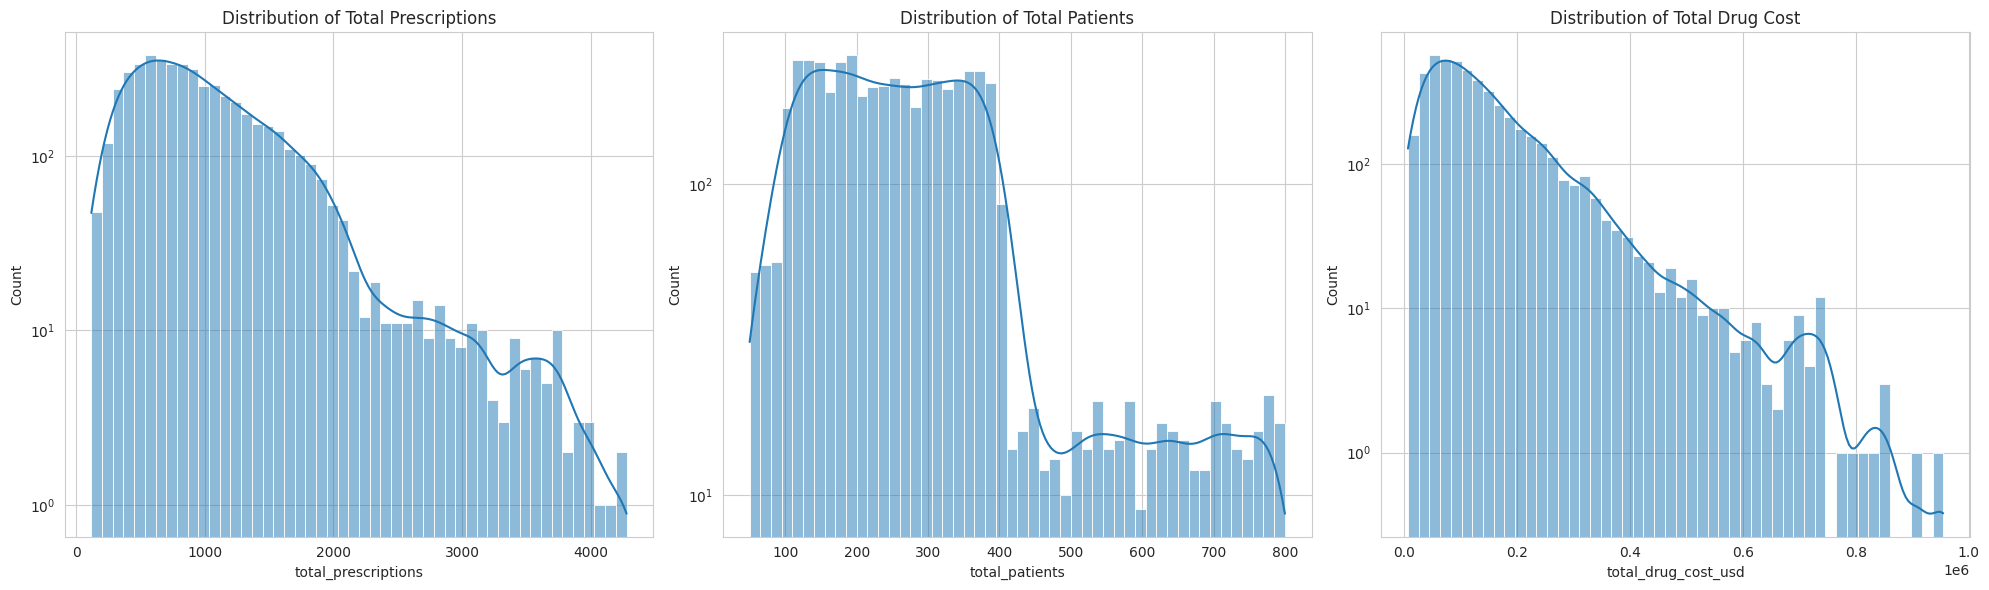

In [21]:
print("--- Data Quality and Overview ---")
df.info()

print("\n--- Descriptive Statistics ---")
display(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.histplot(df[TARGET_COLUMN], bins=50, kde=True, ax=axes[0]).set_title('Distribution of Total Prescriptions')
axes[0].set_yscale('log')

sns.histplot(df[PATIENTS_COLUMN], bins=50, kde=True, ax=axes[1]).set_title('Distribution of Total Patients')
axes[1].set_yscale('log')

sns.histplot(df[COST_COLUMN], bins=50, kde=True, ax=axes[2]).set_title('Distribution of Total Drug Cost')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

## Specialty Analysis

/tmp/ipython-input-2435229537.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




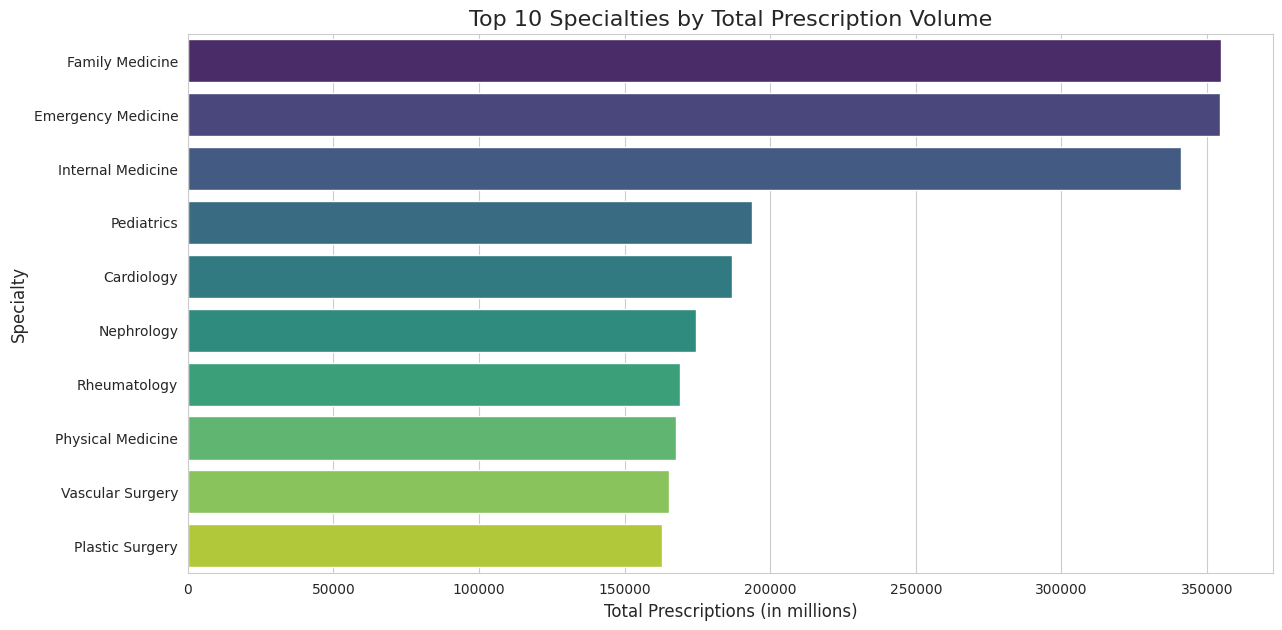

/tmp/ipython-input-2435229537.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




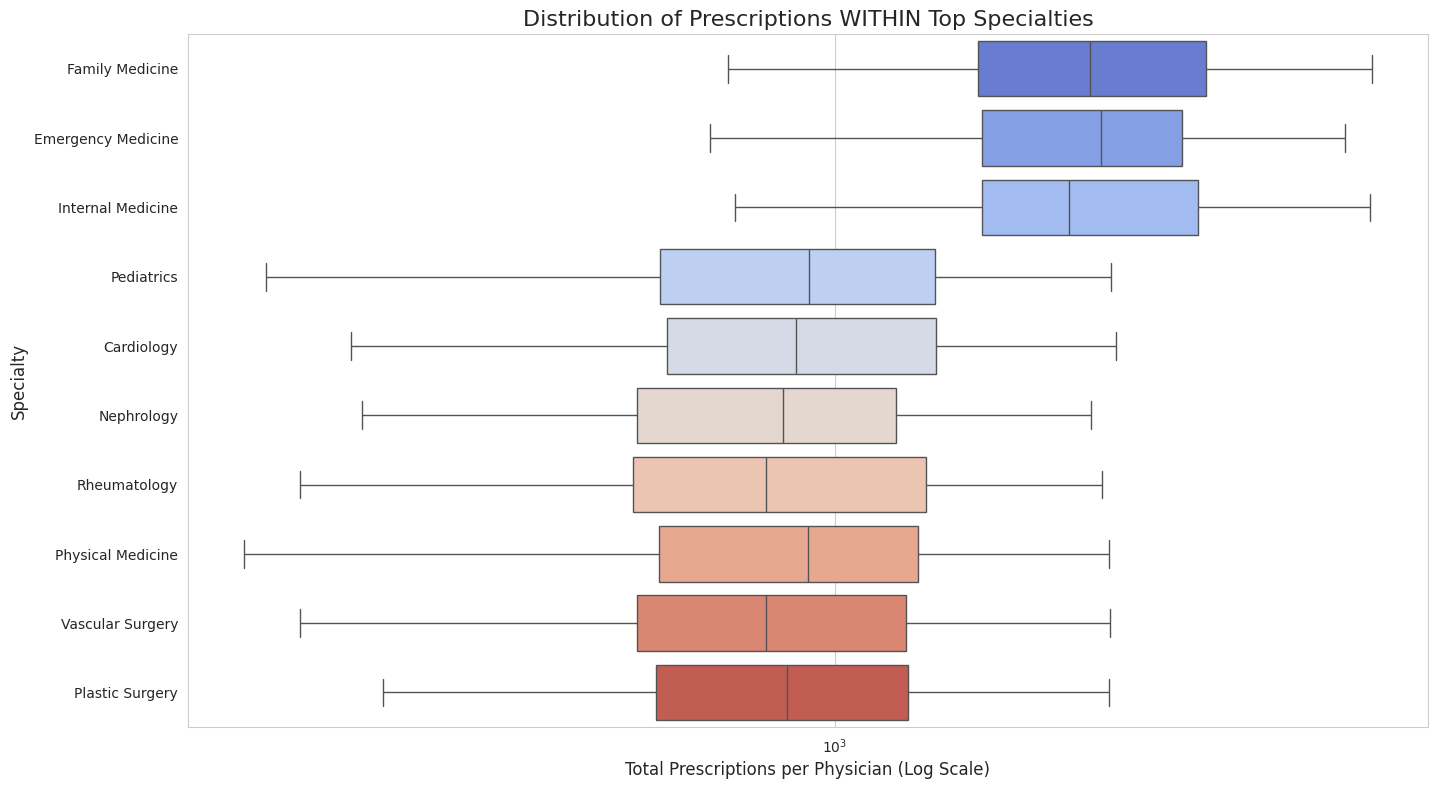

In [22]:
# Top 10 specialties by total prescription volume
top_specialties = df.groupby(SPECIALTY_COLUMN)[TARGET_COLUMN].sum().nlargest(10)

plt.figure(figsize=(14, 7))
sns.barplot(x=top_specialties.values, y=top_specialties.index, palette='viridis')
plt.title('Top 10 Specialties by Total Prescription Volume', fontsize=16)
plt.xlabel('Total Prescriptions (in millions)', fontsize=12)
plt.ylabel('Specialty', fontsize=12)
plt.show()

plt.figure(figsize=(16, 9))
top_specialty_names = top_specialties.index.tolist()
df_top_specialties = df[df[SPECIALTY_COLUMN].isin(top_specialty_names)]

sns.boxplot(y=SPECIALTY_COLUMN, x=TARGET_COLUMN, data=df_top_specialties, order=top_specialty_names, palette='coolwarm')
plt.title('Distribution of Prescriptions WITHIN Top Specialties', fontsize=16)
plt.xlabel('Total Prescriptions per Physician (Log Scale)', fontsize=12)
plt.ylabel('Specialty', fontsize=12)
plt.xscale('log')
plt.show()

## Bivariate Analysis

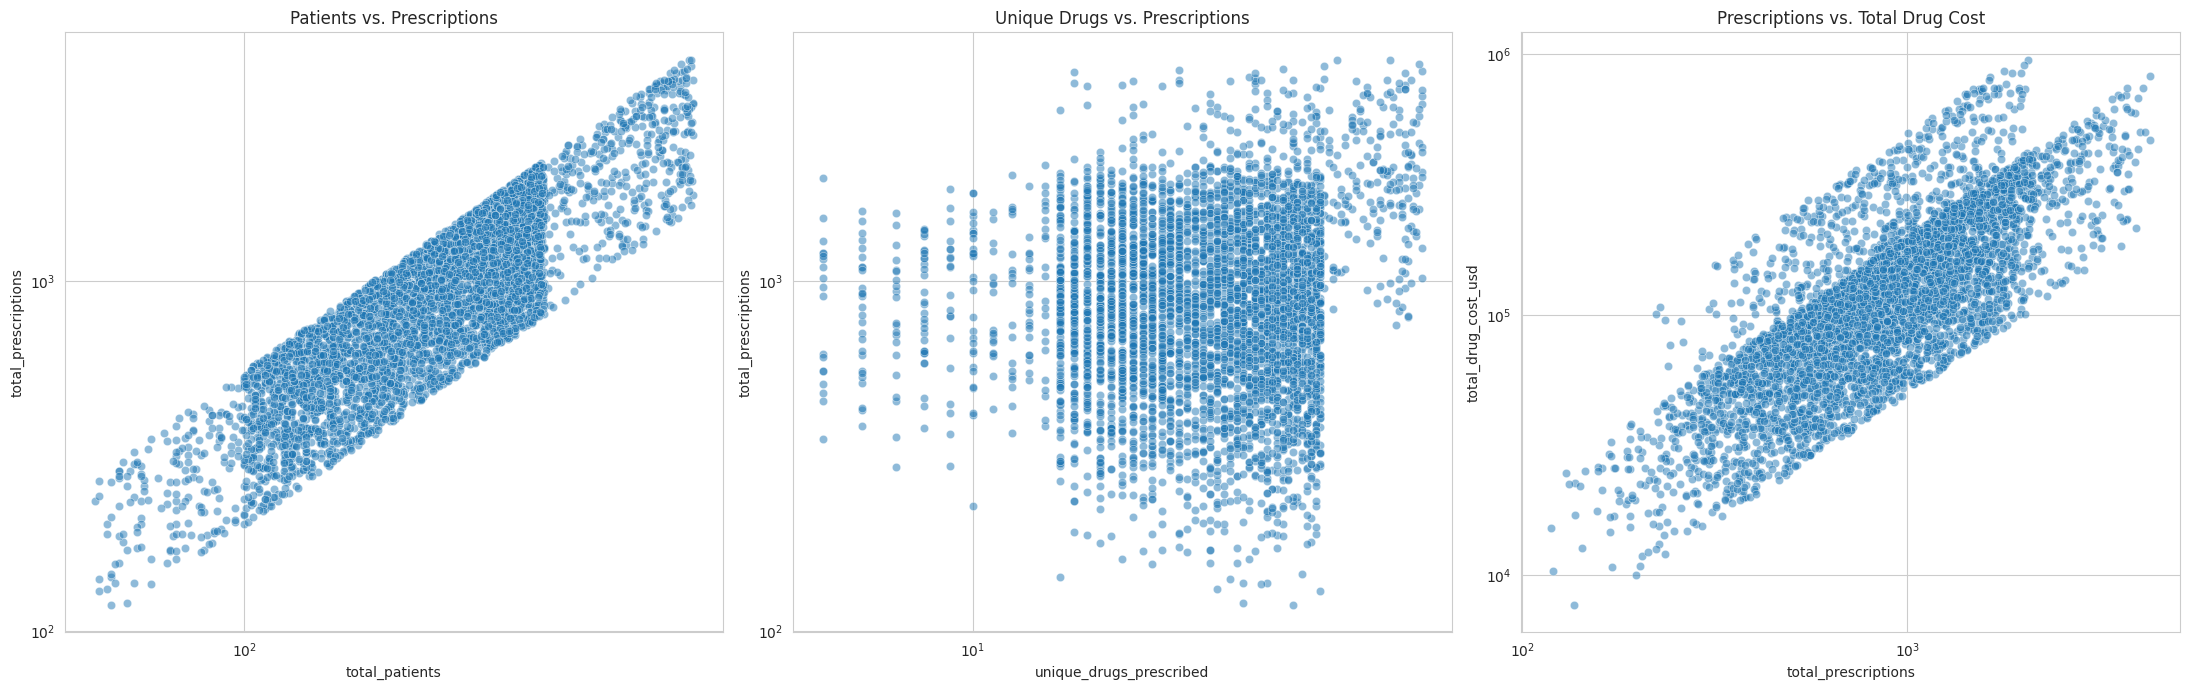

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

sns.scatterplot(x=PATIENTS_COLUMN, y=TARGET_COLUMN, data=df.sample(min(5000, len(df))), alpha=0.5, ax=axes[0])
axes[0].set_title('Patients vs. Prescriptions')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

sns.scatterplot(x=UNIQUE_DRUGS_COLUMN, y=TARGET_COLUMN, data=df.sample(min(5000, len(df))), alpha=0.5, ax=axes[1])
axes[1].set_title('Unique Drugs vs. Prescriptions')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

sns.scatterplot(x=TARGET_COLUMN, y=COST_COLUMN, data=df.sample(min(5000, len(df))), alpha=0.5, ax=axes[2])
axes[2].set_title('Prescriptions vs. Total Drug Cost')
axes[2].set_xscale('log')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

## Geographic Opportunity Mapping

In [30]:
state_data = df.groupby(STATE_COLUMN)[TARGET_COLUMN].sum().reset_index()

fig = px.choropleth(state_data,
                    locations=STATE_COLUMN,
                    locationmode="USA-states",
                    color=TARGET_COLUMN,
                    scope="usa",
                    color_continuous_scale="Viridis_r",
                    title="Total Prescription Volume by State")
fig.show()
print("MAP")


Skipping Top Cities analysis because the 'city' column is not present in the dataset.


## Preprocessing and Feature Engineering

In [26]:
print("--- Preparing Data for Machine Learning ---")
df_ml = df.copy().dropna()
df_ml['cost_per_prescription'] = df_ml[COST_COLUMN] / df_ml[TARGET_COLUMN]
df_ml['prescriptions_per_patient'] = df_ml[TARGET_COLUMN] / df_ml[PATIENTS_COLUMN]


df_ml.replace([np.inf, -np.inf], 0, inplace=True)
df_ml = df_ml.fillna(0)

numerical_features = [PATIENTS_COLUMN, COST_COLUMN, UNIQUE_DRUGS_COLUMN,
                      'cost_per_prescription', 'prescriptions_per_patient']

top_n_specialties = df_ml[SPECIALTY_COLUMN].value_counts().nlargest(20).index
df_ml['specialty_group'] = df_ml[SPECIALTY_COLUMN].apply(lambda x: x if x in top_n_specialties else 'Other')

categorical_features = ['specialty_group', STATE_COLUMN]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

print("Feature engineering complete. Preprocessing pipeline is ready.")
display(df_ml.head())

--- Preparing Data for Machine Learning ---
Feature engineering complete. Preprocessing pipeline is ready.


,physician_id,specialty_description,state,total_patients,total_prescriptions,total_drug_cost_usd,unique_drugs_prescribed,cost_per_prescription,prescriptions_per_patient,specialty_group
0,1786579303,Orthopedics,AK,240,685,"48,587.52",21,70.93,2.85,Orthopedics
1,1826600539,Family Medicine,OH,344,1398,"76,564.83",35,54.77,4.06,Family Medicine
2,1334760738,Emergency Medicine,NC,608,1272,"101,538.22",49,79.83,2.09,Emergency Medicine
3,1550455977,Emergency Medicine,NH,601,1787,"322,365.95",25,180.40,2.97,Emergency Medicine
4,1849621470,Ophthalmology,MI,242,615,"149,276.63",36,242.73,2.54,Ophthalmology


## Unsupervised Segmentation with K-Means Clustering

--- Finding Optimal Number of Clusters using the Elbow Method ---


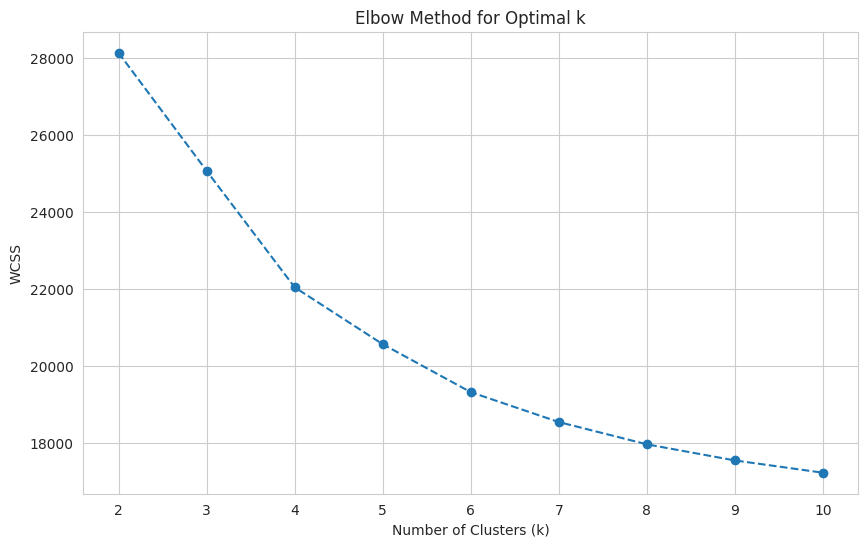


Optimal k selected: 4. Now training final K-Means model...

--- Analyzing Physician Segments ---


,total_patients,total_drug_cost_usd,unique_drugs_prescribed,cost_per_prescription,prescriptions_per_patient,segment_size
segment,,,,,,
0,266.22,"381,105.34",31.18,378.70,3.83,322
1,229.80,"82,733.44",31.01,129.30,2.87,2119
2,244.01,"149,204.79",29.89,134.34,4.62,2104
3,571.62,"285,459.71",50.69,132.02,3.86,455


In [27]:
print("--- Finding Optimal Number of Clusters using the Elbow Method ---")
X_processed = preprocessor.fit_transform(X_for_ml)
wcss = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_processed)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

OPTIMAL_K = 4
print(f"\nOptimal k selected: {OPTIMAL_K}. Now training final K-Means model...")
kmeans = KMeans(n_clusters=OPTIMAL_K, init='k-means++', random_state=42, n_init='auto')
df_ml['segment'] = kmeans.fit_predict(X_processed)

print("\n--- Analyzing Physician Segments ---")
segment_analysis = df_ml.groupby('segment')[numerical_features].mean().round(2)
segment_analysis['segment_size'] = df_ml['segment'].value_counts()
display(segment_analysis)

 ## Supervised Prediction with Random Forest

In [28]:
print("--- Training Predictive Model (Random Forest Regressor) ---")
y = df_ml[TARGET_COLUMN]

features_for_rf = numerical_features + categorical_features + ['segment']
X_for_rf = df_ml[features_for_rf]


numerical_features_rf = numerical_features
categorical_features_rf = ['specialty_group', STATE_COLUMN, 'segment']

preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_rf),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_rf)
    ],
    remainder='drop'
)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True))
])

X_train, X_test, y_train, y_test = train_test_split(X_for_rf, y, test_size=0.2, random_state=42)
rf_pipeline.fit(X_train, y_train)

predictions = rf_pipeline.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"\nModel Performance (R-squared): {r2:.2f}")
df_ml['predicted_prescriptions'] = rf_pipeline.predict(X_for_rf)

ohe_feature_names = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features_rf)
all_feature_names = numerical_features_rf + list(ohe_feature_names)
importances = rf_pipeline.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances}).sort_values('importance', ascending=False)

print("\n--- Top 10 Most Important Features for Prediction ---")
display(feature_importance_df.head(10))

--- Training Predictive Model (Random Forest Regressor) ---

Model Performance (R-squared): 1.00

--- Top 10 Most Important Features for Prediction ---


,feature,importance
0,total_patients,0.74
4,prescriptions_per_patient,0.25
77,segment_1,0.01
1,total_drug_cost_usd,0.00
2,unique_drugs_prescribed,0.00
3,cost_per_prescription,0.00
75,state_WY,0.00
10,specialty_group_Internal Medicine,0.00
6,specialty_group_Emergency Medicine,0.00
7,specialty_group_Family Medicine,0.00
